In [1]:
# importing of libaries
import numpy as np                      #functions for scientific computing, faster arrays
import pandas as pd                     #easy import and export of data, fast and easy-to-use datastructure
import math                             #mathematical functions
import matplotlib.pyplot as plt         #generation of Graphs
import seaborn as sns                   #generation of Graphs
import scipy as sci
from scipy.constants import pi, g       #fundamental Constants
import Leistung as lei                  #Eigenes Modul um Leistung und Fahrtwiderstaende zu berechnen 
from sklearn.cluster import KMeans      # Für K mean clustering

In [2]:
# document paths
path_data_idle1 = "data/idle1.csv"
path_data_drive1 = "data/drive1.csv"
path_data_live1 = "data/live1.csv"
path_data_ufpe1 = "data/ufpe1.csv"
path_data_long1 = "data/long1.csv"
graphs ="graphs/"

paths = (path_data_idle1, path_data_drive1, path_data_live1, path_data_ufpe1, path_data_long1)
length = len(paths)
data = list()  #list of pandas Dataframes
names = list() #list of the names of the data sets
for i in range(length):
    data.append(pd.read_csv(paths[i]))
    data[i]["VEHICLE_SPEED ()"] = data[i]["VEHICLE_SPEED ()"]/3.6 #transformation from kmh to m/s
    data[i]["ENGINE_RPM ()"] = data[i]["ENGINE_RPM ()"]/60 #transformieren von rpm zu u/s, name für kompabilitaet beinehalten
    names.append(paths[i][5:-4]) #Abschneiden von data/ und .csv

In [3]:
# Constants
d_wheel = .583 #m Reifendurchmesser
#Source: https://tirewheelguide.de/sizes/toyota/etios-liva/2014/

In [4]:
# Wheel rotation from speed
# pV: speed in m/s
def n_Rad(pV):
    return (pV) / (d_wheel * pi)

In [5]:
for i in range(length):
    data[i]= data[i].assign(N_RAD = data[i]['VEHICLE_SPEED ()'].apply(n_Rad))

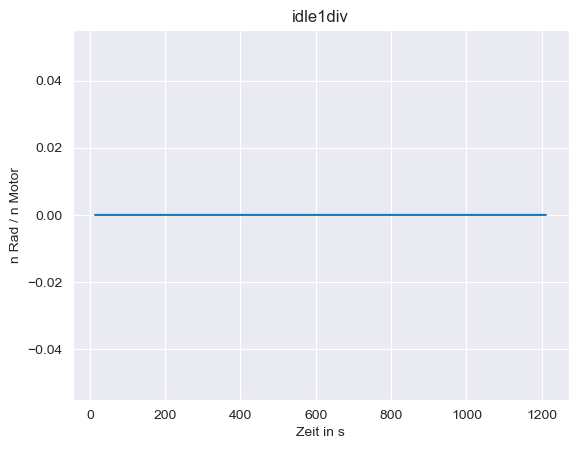

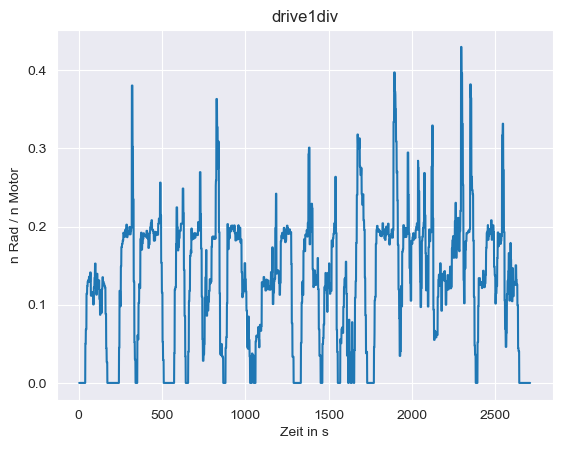

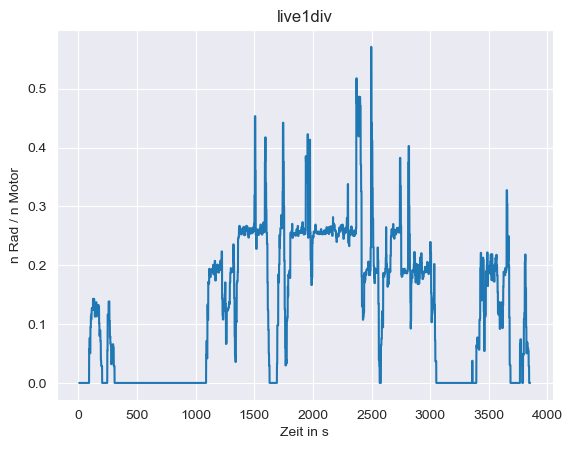

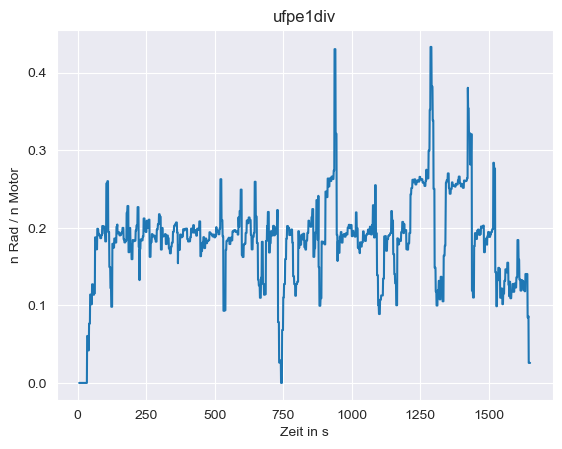

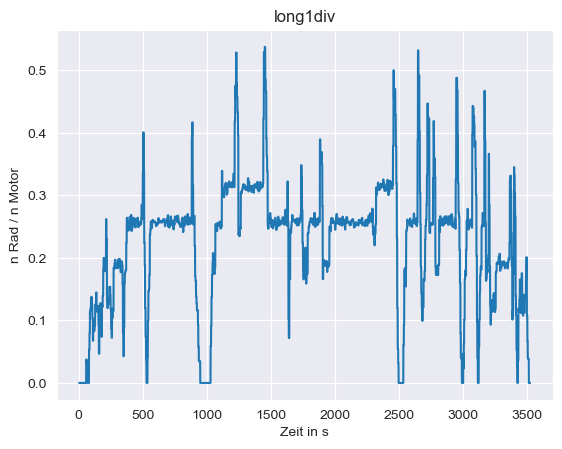

In [6]:
for i in range(length):
    local_length = int(data[i].shape[0])
    div = np.zeros(length)
    div = data[i]["N_RAD"]/data[i]["ENGINE_RPM ()"]
    data[i] = data[i].assign(DIV=div)
    plt.plot(div)
    plt.title(names[i]+"div")
    plt.xlabel("Zeit in s")
    plt.ylabel("n Rad / n Motor")
    plt.savefig(graphs+"div_"+names[i]+".png")
    plt.grid(True)
    plt.show()

weiteres vorgehen für die Bestimmung der Gänge, bereiche in denen sich die Drehzahl länger aufhält finden und für den x bereich den Durchschnitt bilden

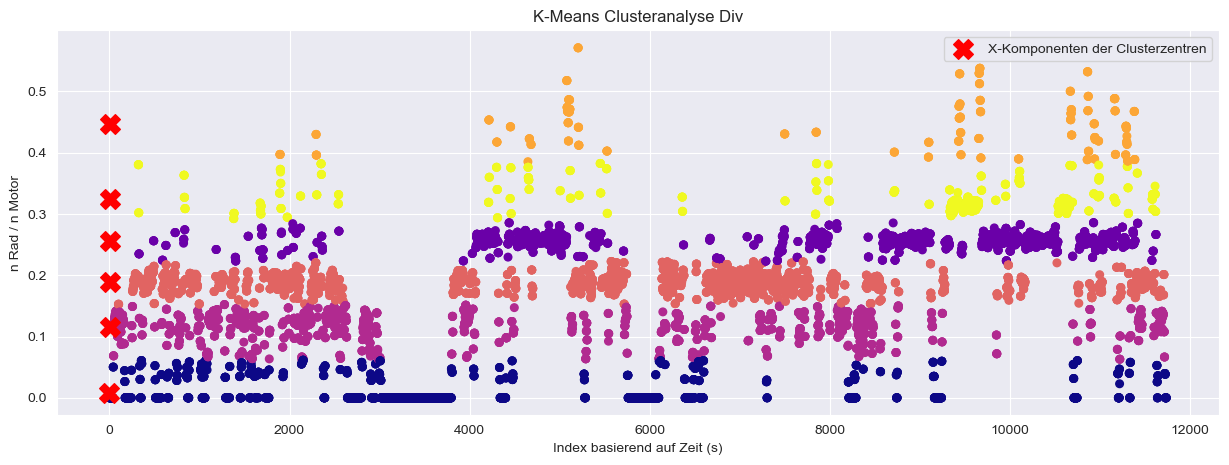

In [7]:
# finden dieser Punkte über K mean Clustering
kmeans = KMeans(n_clusters= 6)
temp = data[1]["DIV"].to_numpy(na_value= 0)
for i in range(2,length):
    temp = np.append(temp,data[i]["DIV"].to_numpy(na_value= 0))
temp= temp.reshape(-1,1)
kmeans.n_init = 300
kmeans.fit(temp)
# Erhalte die zugeordneten Clusterzentren und die Zuordnung der Datenpunkte zu den Clustern
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

labels
# Visualisiere die Cluster
u_labels = np.unique(labels)
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(len(temp)),temp[:,0], c=labels, s=30, cmap='plasma')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 0], marker='X', s=200, color='red', label="X-Komponenten der Clusterzentren")
plt.title('K-Means Clusteranalyse Div')
plt.xlabel('Index basierend auf Zeit (s)')
plt.ylabel("n Rad / n Motor")
plt.legend()
plt.savefig(graphs+"kmeans.png",dpi=300)
plt.show()


In [8]:
# zuordnen und sortieren der cluster zu den gaengen
clus = pd.DataFrame(cluster_centers, columns=['center'])
clus = clus.assign(label=np.arange(len(cluster_centers)))
clus = clus.sort_values(by='center')
clus = clus.assign(gang=np.arange(len(cluster_centers)))
# zuordnung der Gaenge zu den Punkten, erste beiden CLuster werden dem 1. Gang zugeordnet
gaenge = np.zeros(len(labels))
for i in range(len(gaenge)):
    gang = clus["gang"][labels[i]] #zuordnung über ausnutzung des index
    if 0 == gang: 
        gaenge[i] = 1                   #zuordnung des ersten ganges für untersten bereich
    else: 
        gaenge[i] = gang
# Uebertragen auf dataframes
for i in range(1, length): # 1, da leerlauf nicht betrachtet
    data[i] = data[i].assign(GANG=gaenge[:int(data[i].shape[0])]) #nur bis laenge des jeweiligen dataframes
    gaenge = gaenge[int(data[i].shape[0]) :] #loeschen des zugeordneten bereiches

In [9]:
# Uebersetzung bestimmen i = i_A \cdot i_G
clus = clus.assign(uebersetzungsverhaeltnis = 1/clus["center"]) # wert fuer 0 ohne bedeutung
# loeschen der saeulen fuer den Export
clus = clus.drop("center", axis=1)
clus = clus.drop("label", axis=1)
clus.to_latex("clus.txt") #ausgabe als Tabelle in Latex

## Beschleunigung

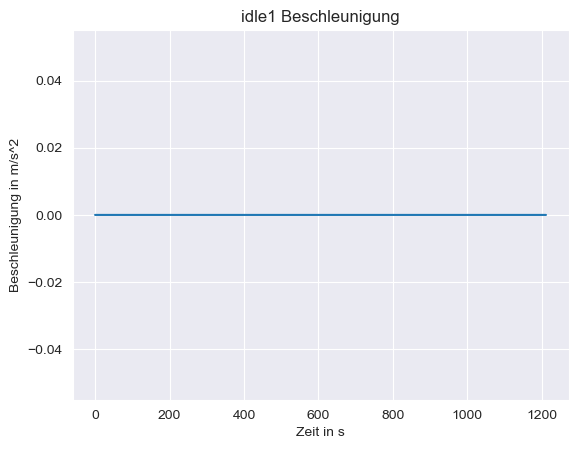

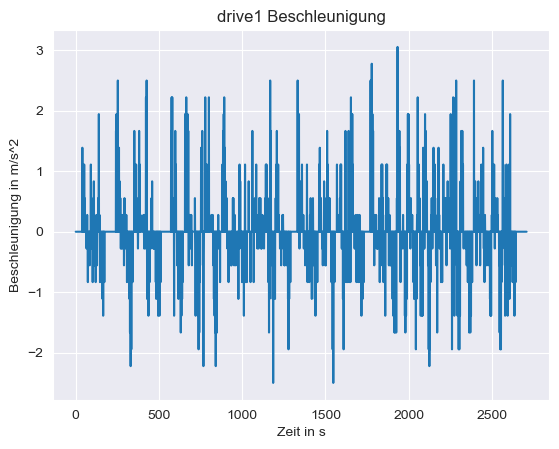

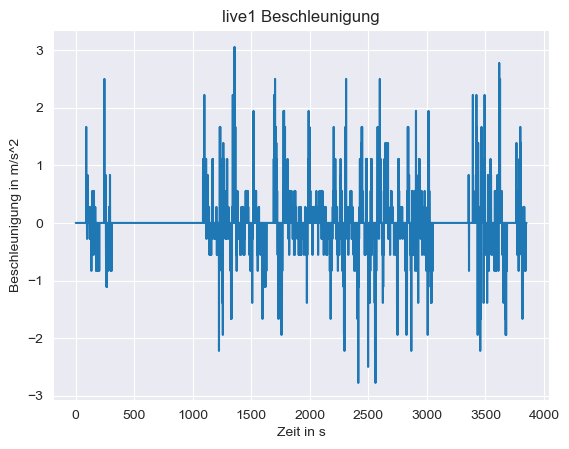

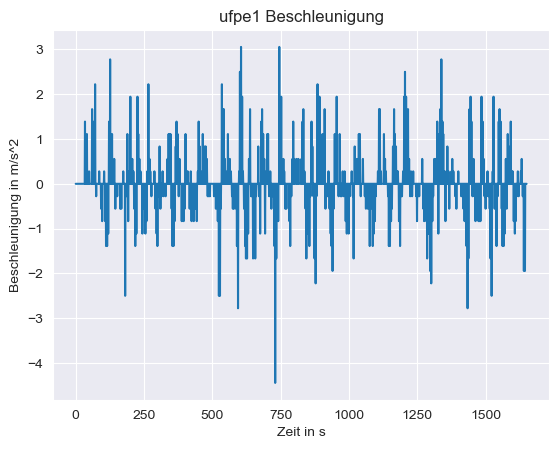

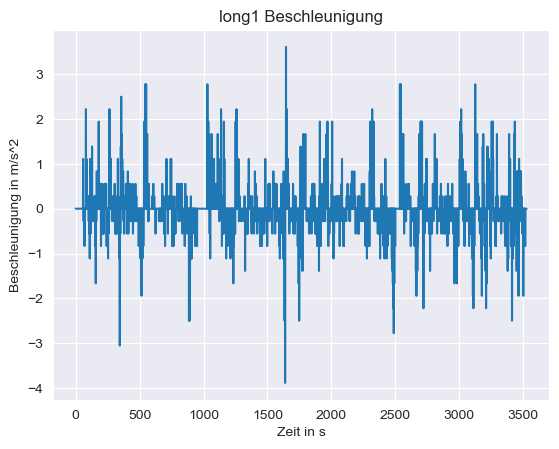

In [10]:
for i in range(length):   
    local_length = int(data[i].shape[0])
    acc =np.zeros(local_length)
    for j in range(local_length-1):
        acc[j]=data[i]["VEHICLE_SPEED ()"][j+1]-data[i]["VEHICLE_SPEED ()"][j] #teilen durch Zeit entfällt, da delta t = 1s
    
    data[i] = data[i].assign(BESCHLEUNIGUNG =acc)
    plt.plot(acc)
    plt.title(names[i]+" Beschleunigung")
    plt.xlabel("Zeit in s")
    plt.ylabel("Beschleunigung in m/s^2")
    plt.grid(True)
    plt.savefig(graphs+"beschleunigung_"+names[i]+".png",dpi=300)
    plt.show()

In [11]:
# zum test berechnung der Geschwindigkeit auf grundlage der ermittelten Beschleunigung
#gesch =np.zeros(length) 
#for i in range(length):
    #if 0 != i:
   #     gesch[i] = gesch[i-1]+acc[i-1] #mal zeit entfällt, da delta t = 1s
  #  else:
 #       gesch[i] = 0
#plt.plot(data_drive1["VEHICLE_SPEED ()"],color="orange",linewidth=4)
#plt.plot(gesch,color="blue",linewidth=1)
#plt.xlabel("Zeit in s")
#plt.ylabel("Geschwindigkeit")
#plt.grid(True)
#plt.savefig("gesch.png")
#plt.show()

## Power

In [12]:

def leistung_1(pDataframe):
    laenge = int(pDataframe.shape[0]) #Bestimmung der Laenge des Dataframes
    leist = np.zeros(laenge)
    for i in range(laenge-1):
        leist[i] = lei.leistung_1(pDataframe["VEHICLE_SPEED ()"][i],pDataframe["BESCHLEUNIGUNG"][i],0)
    return leist

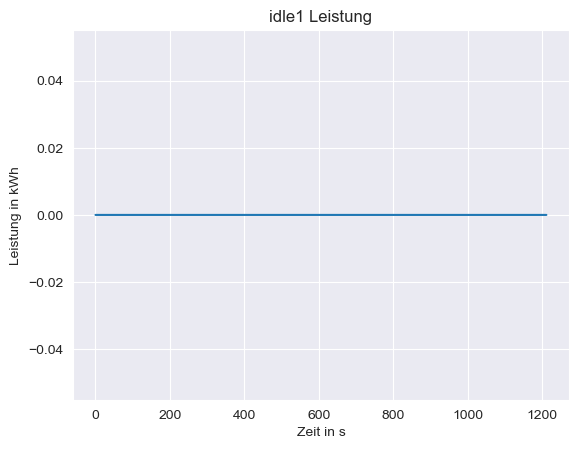

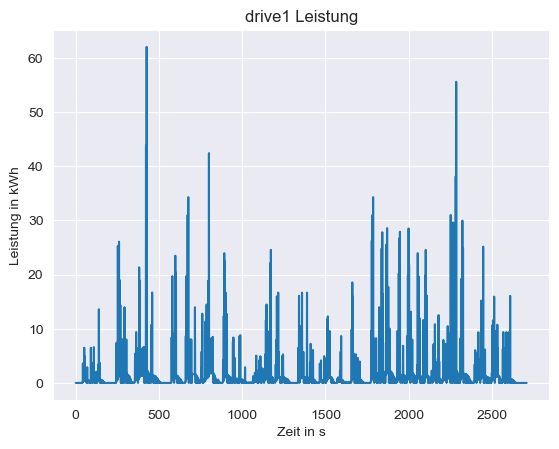

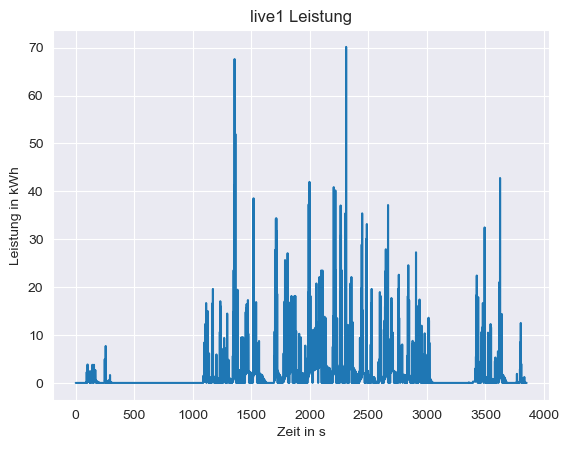

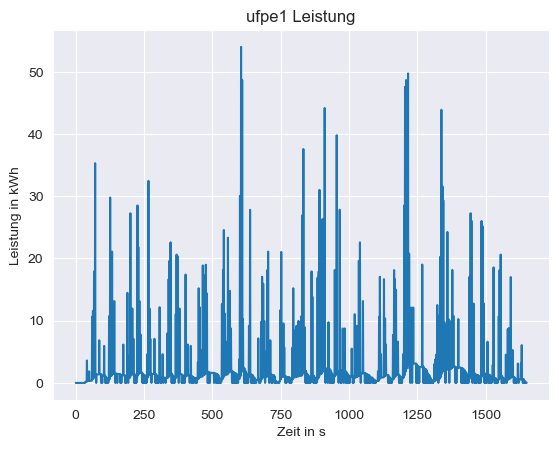

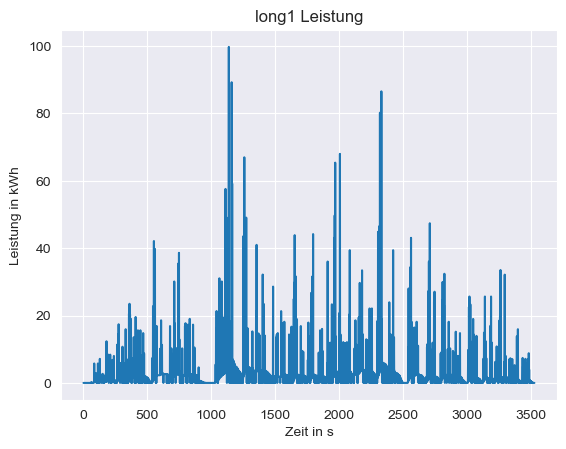

In [13]:
for i in range(length):
    local_length = int(data[i].shape[0])
    leist = np.zeros(local_length)
    for j in range(local_length-1):
        leist[j] = lei.leistung_1(data[i]["VEHICLE_SPEED ()"][j],data[i]["BESCHLEUNIGUNG"][j],0) #Funktion zur Berechnung der Aktuellen Leistung
    data[i] = data[i].assign(LEISTUNG=leist)
    plt.plot(leist/1000)
    plt.title(names[i]+" Leistung")
    plt.xlabel("Zeit in s")
    plt.ylabel("Leistung in kWh")
    plt.grid(True)
    plt.savefig(graphs+"leistung_"+names[i]+".png",dpi=300)
    plt.show()

## Drehmoment

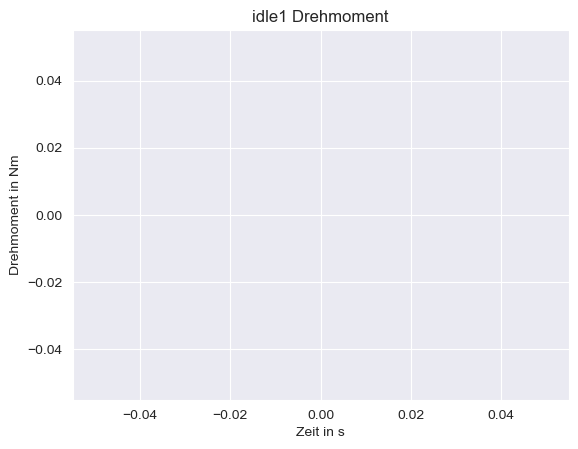

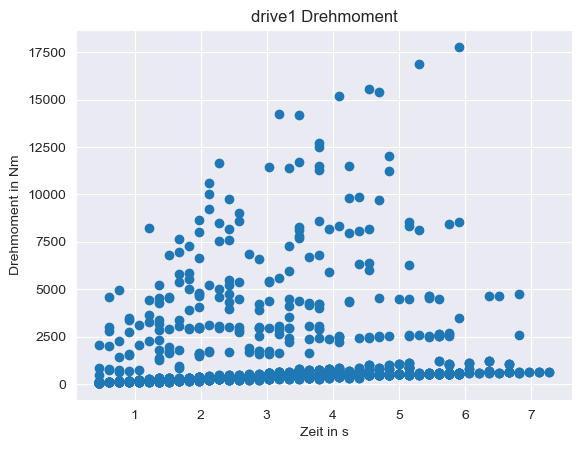

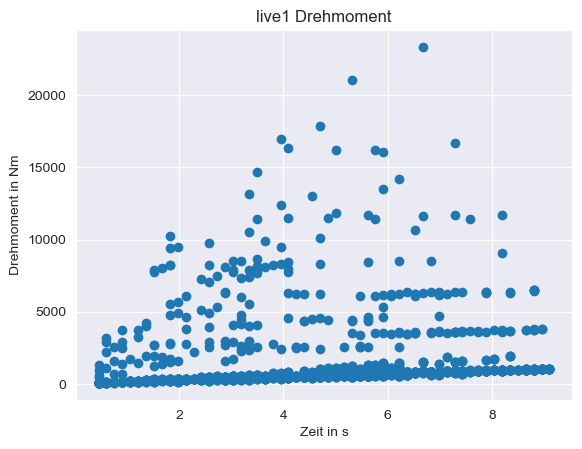

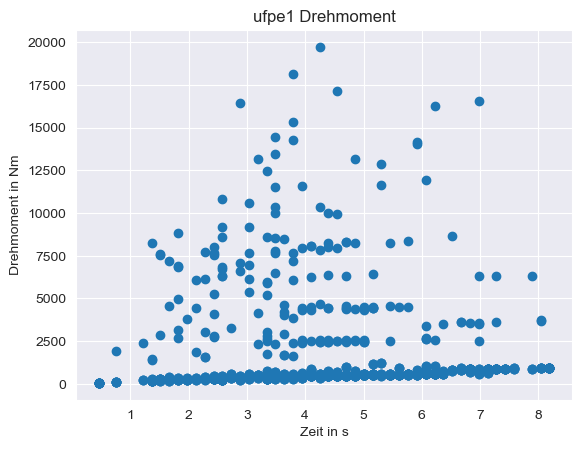

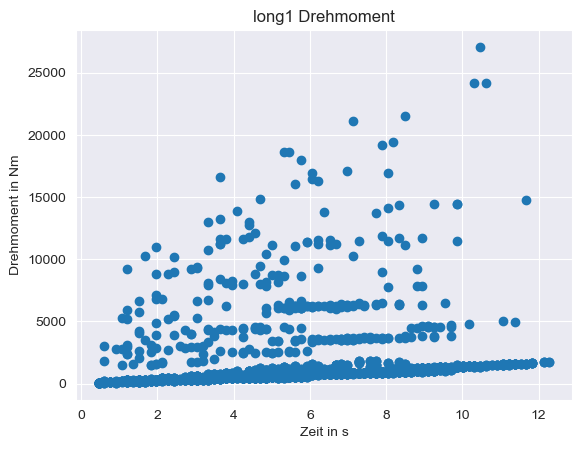

In [15]:
# Berechnung des Drehmomentes aus Leistung und RPM
# Aktuell werden gänge noch nicht berücksichtigt
for i in range(length):
    local_length = int(data[i].shape[0])
    drehM = np.zeros(local_length)
    for j in range(local_length-1):
        if 0 != data[i]["ENGINE_RPM ()"][j]:
            drehM[j] = (data[i]["LEISTUNG"][j]*9.550)/((data[i]["ENGINE_RPM ()"][j]))
        else:            #für den Fall das n = 0, ist die Formel oben nicht definiert, da der Motor in diesem Fall steht wird M = 0 gesetzt
            drehM[j] = 0
    data[i] = data[i].assign(DREHMOMENT=drehM)
    temp_data = data[i].sort_values(by=["N_RAD"])
    temp_data = temp_data.drop(temp_data[temp_data["LEISTUNG"]==0].index)
    plt.scatter(temp_data["N_RAD"],temp_data["DREHMOMENT"])
    plt.title(names[i]+" Drehmoment")
    plt.xlabel("Zeit in s")
    plt.ylabel("Drehmoment in Nm")
    plt.grid(True)
    plt.savefig(graphs+"drehmoment_"+names[i]+".png",dpi=300)
    plt.show()

In [16]:
data[1]

,Index (),ENGINE_RUN_TINE (),ENGINE_RPM (),VEHICLE_SPEED (),THROTTLE (),ENGINE_LOAD (),COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),SHORT_TERM_FUEL_TRIM_BANK_1 (),INTAKE_MANIFOLD_PRESSURE (),...,TIME_RUN_WITH_MIL_ON (),TIME_SINCE_TROUBLE_CODES_CLEARED (),DISTANCE_TRAVELED_WITH_MIL_ON (),WARM_UPS_SINCE_CODES_CLEARED (),N_RAD,DIV,GANG,BESCHLEUNIGUNG,LEISTUNG,DREHMOMENT
0,0,0,0.000000,0.0,17.647058,0.000000,81,-4.6875,0.00000,101,...,0,8260,0,255,0.0,NaN,1.0,0.0,0.0,0.0
1,0,0,0.000000,0.0,17.647058,0.000000,81,-4.6875,0.00000,101,...,0,8260,0,255,0.0,NaN,1.0,0.0,0.0,0.0
2,0,0,0.000000,0.0,17.647058,0.000000,81,-4.6875,0.00000,101,...,0,8260,0,255,0.0,NaN,1.0,0.0,0.0,0.0
3,0,0,0.000000,0.0,17.647058,0.000000,81,-4.6875,0.00000,101,...,0,8260,0,255,0.0,NaN,1.0,0.0,0.0,0.0
4,0,0,4.087500,0.0,17.254902,88.627449,81,-4.6875,0.00000,83,...,0,8260,0,255,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,0,1328,11.054167,0.0,15.686275,23.921568,89,-1.5625,0.78125,26,...,0,8282,0,255,0.0,0.0,1.0,0.0,0.0,0.0
2705,0,1328,10.975000,0.0,15.686275,23.921568,89,-1.5625,-2.34375,24,...,0,8282,0,255,0.0,0.0,1.0,0.0,0.0,0.0
2706,0,1330,10.975000,0.0,15.686275,23.921568,89,-1.5625,-2.34375,24,...,0,8282,0,255,0.0,0.0,1.0,0.0,0.0,0.0
2707,0,1330,10.975000,0.0,15.686275,23.921568,89,-1.5625,-2.34375,24,...,0,8282,0,255,0.0,0.0,1.0,0.0,0.0,0.0


## Comparison Plots

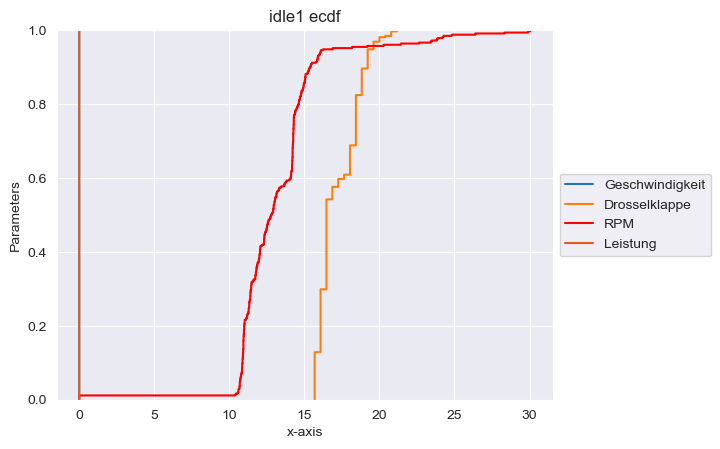

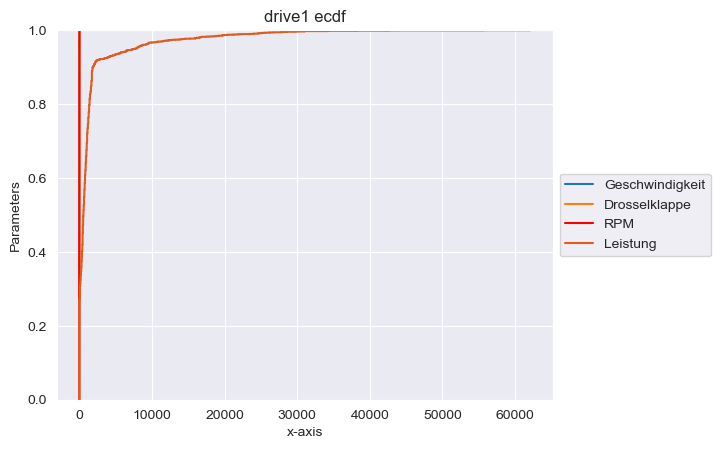

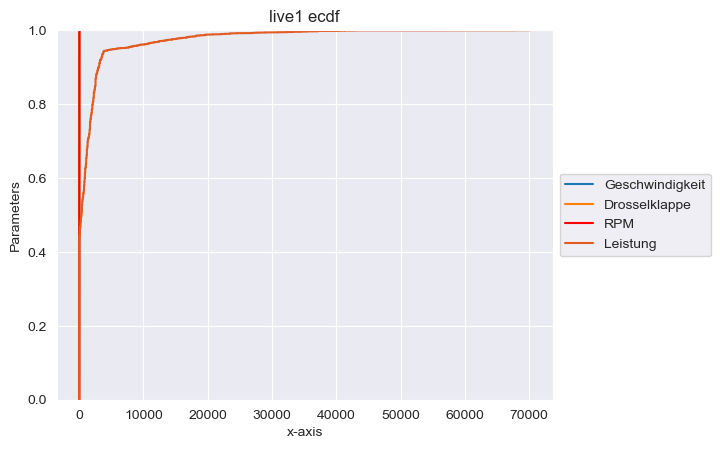

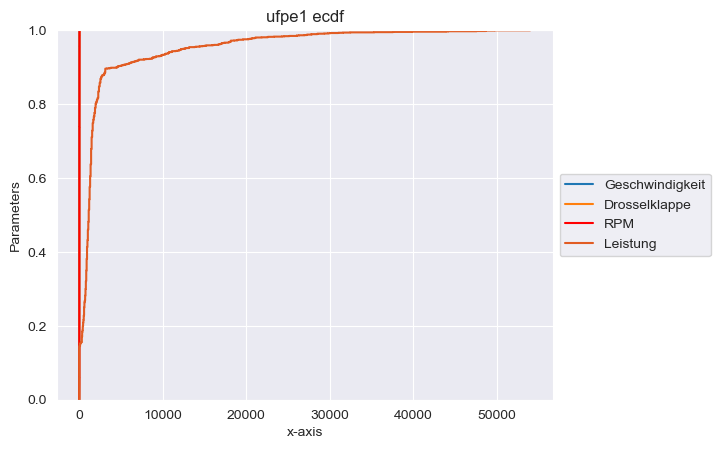

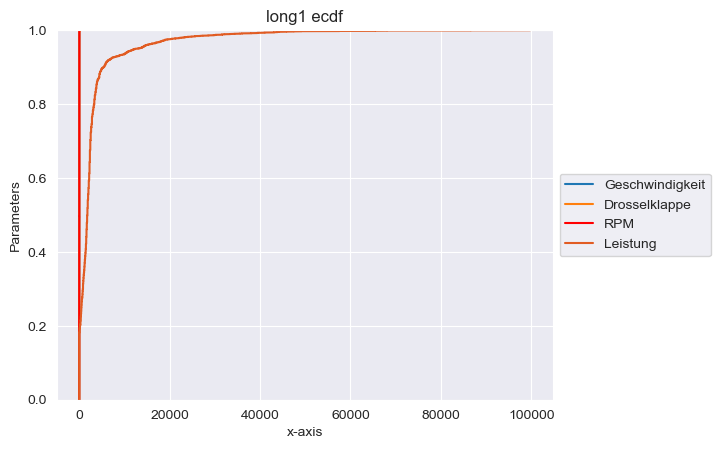

In [17]:
# per Mode
for i in range(length):
    #plt.style.use('_mpl-gallery-nogrid')
    plt.ecdf(data[i]["VEHICLE_SPEED ()"], label='Geschwindigkeit')
    plt.ecdf(data[i]["THROTTLE ()"], label='Drosselklappe')
    plt.ecdf(data[i]["ENGINE_RPM ()"], label='RPM', color="red")
    plt.ecdf(data[i]["LEISTUNG"], label='Leistung', color="#E15C23")
    
    plt.title(names[i]+" ecdf")
    plt.xlabel('x-axis')
    plt.ylabel('Parameters')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(graphs+"ecdf_"+names[i]+".png",dpi=300, bbox_inches='tight')
    plt.show()

### Pearson Correlation
describes the strength and direction of an linear correlation between two continous datasets

In [18]:
# Geschwindigkeit und Leistung 
# r:statistics
# If r = 1, it indicates a perfect positive linear relationship.
# If r = -1, it indicates a perfect negative linear relationship.
# If r = 0, it indicates no linear relationship between the variables.
# p > 0.05 keine Korrelation
# p < 0.05 eine Korrelation
print("Pearson Geschwindigkeit und Leistung:")
for i in range(length):
    print(names[i])
    print(sci.stats.pearsonr(data[i]["VEHICLE_SPEED ()"],data[i]["LEISTUNG"]))

Pearson Geschwindigkeit und Leistung:
idle1
PearsonRResult(statistic=nan, pvalue=nan)
drive1
PearsonRResult(statistic=0.2179600121756242, pvalue=1.7132697236397572e-30)
live1
PearsonRResult(statistic=0.3429812463614293, pvalue=8.273456767257525e-107)
ufpe1
PearsonRResult(statistic=0.093378810335781, pvalue=0.00014490338506707539)
long1
PearsonRResult(statistic=0.22859120085464613, pvalue=4.731299431289965e-43)


/Users/julius/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
# Drosselklappe und Leistung 
# If r = 1, it indicates a perfect positive linear relationship.
# If r = -1, it indicates a perfect negative linear relationship.
# If r = 0, it indicates no linear relationship between the variables.
# p > 0.05 keine Korrelation
# p < 0.05 eine Korrelation
print("Pearson Drosselklappe und Leistung:")
for i in range(length):
    print(names[i])
    print(sci.stats.pearsonr(data[i]["THROTTLE ()"],data[i]["LEISTUNG"]))

Pearson Drosselklappe und Leistung:
idle1
PearsonRResult(statistic=nan, pvalue=nan)
drive1
PearsonRResult(statistic=0.3932565346126504, pvalue=6.817100219094546e-101)
live1
PearsonRResult(statistic=0.43473859678513926, pvalue=1.961078675820774e-177)
ufpe1
PearsonRResult(statistic=0.375288056298057, pvalue=2.295586989085299e-56)
long1
PearsonRResult(statistic=0.4085348550757749, pvalue=5.067641338878227e-142)


In [20]:
# RPM und Leistung 
# If r = 1, it indicates a perfect positive linear relationship.
# If r = -1, it indicates a perfect negative linear relationship.
# If r = 0, it indicates no linear relationship between the variables.
# p > 0.05 keine Korrelation
# p < 0.05 eine Korrelation
print("Pearson RPM und Leistung:")
for i in range(length):
    print(names[i])
    print(sci.stats.pearsonr(data[i]["ENGINE_RPM ()"],data[i]["LEISTUNG"]))

Pearson RPM und Leistung:
idle1
PearsonRResult(statistic=nan, pvalue=nan)
drive1
PearsonRResult(statistic=0.2745432995759667, pvalue=4.788544621627728e-48)
live1
PearsonRResult(statistic=0.3594098199577345, pvalue=7.7500099620462024e-118)
ufpe1
PearsonRResult(statistic=0.1658422665746152, pvalue=1.1977217532322716e-11)
long1
PearsonRResult(statistic=0.2713689618681033, pvalue=1.3336123297096687e-60)


## Ausgabe

In [26]:
for i in range(length):
    data[i].to_csv("data/v2_"+names[i]+".csv")
    data[i].to_excel("data/v2_"+names[i]+".xlsx")

In [24]:
# output of key values
dauer = np.zeros(length) # in s
max_geschwindigkeit = np.zeros(length) # in km/h
max_beschleunigung = np.zeros(length) # in m/s^2
min_beschleunigung = np.zeros(length) # in m/s^2
max_Leistung = np.zeros(length) #in kW
min_Leistung = np.zeros(length) #in kW
for i in range(length):
    dauer[i] = int(data[i].shape[0])
    max_geschwindigkeit[i] = round(data[i]["VEHICLE_SPEED ()"].max(),2)
    max_beschleunigung[i] = round(data[i]["BESCHLEUNIGUNG"].max(),2)
    min_beschleunigung[i] = round(data[i]["BESCHLEUNIGUNG"].min(),2)
    max_Leistung[i] =  round(data[i]["LEISTUNG"].max()/1000,2)
    min_Leistung[i] = round(data[i]["LEISTUNG"].min()/1000,2)

output = pd.DataFrame({"Dauer in s": dauer,
                       "max Geschwindigkeit in m/s": max_geschwindigkeit,
                       "max Geschwindigkeit in km/h":max_geschwindigkeit*3.6,
                       "max Beschleunigung in m/s^2": max_beschleunigung,
                       "min Beschleunigung im m/s^2": min_beschleunigung,
                       "max Leistung in kW": max_Leistung,
                       "min Leistung in kW": min_Leistung}
                      ,index = names)
output.to_excel("output.xlsx")
output.to_latex("output.tex",index=False)